# Kaggle Competition: Natural Language Processing with Disaster Tweets

https://www.kaggle.com/c/nlp-getting-started/overview

Submission notebook by Richard Kaldenhoven

Version 1: March 2, 2021


## 1. Problem Description

"Natural Language Processing with Disaster Tweets" is a Getting Started competition on Kaggle where the goal is to build a machine learning model that can predict whether a tweet is about a natural disaster or not.

For the purposes of this competition, data for approximately 10000 tweets is provided. The data is split into two sets: a training set and a test set. The training set contains the tweet id, keyword, location, the tweet text, and a label for whether the tweet is about a disaster or not. The test set contains the same information except for labels as it is meant to be fed to a completed machine learning model that generates the labels, or predictions, for each tweet. The predictions that the completed machine learning model generates are submitted to Kaggle for evaluation (see Section 2) and scoring.

## 2. Choosing a Measure of Success

The tweets in the dataset used for this problem are labelled "1" if they are about a natural disaster, and "0" if they are not, making it a binary classification problem. For this competition, Kaggle has set the measure of success of machine learning models to be the F1 score, which is defined mathematically as:

$$
F1 = 2 * \frac{precision * recall}{precision + recall}
$$

Where:

$$
precision = \frac{TP}{TP + FP} \\
recall = \frac{TP}{TP + FN}
$$

and

$$
TP = true\ positive \\
FP = false\ positive \\
FN = false\ negative \\
$$

The F1 score is used in classification problems as a measure of the machine learning model's prediction accuracy, and is the harmonic mean of the precision and recall, two other classification metrics. The F1 score is a value between 0 and 1, with a value of 1 indicating perfect precision and recall. Precision and recall are similar performance metrics that should both be considered, and by combining them into the F1 score, a simpler single value performance metric is obtained.

The meaning of precision and recall can be better understood by examining the mathematical definitions provided above. Precision is a measure of the proportion of positive predictions (TP) that are actually correct (TP + FP is the sum of all positive predictions). Recall is a measure of the proportion of actual positive predictions (TP) that are made correctly (TP + FN is the sum of actual positives). Both precision and recall are values between 0 and 1.

## 3. Evaluation Protocol

Reaching an ideal model configuration will require experimentation, so to evaluate the performance of machine learning models that will be developed a validation set will be created from the training data set provided by Kaggle, after the training set has been randomly shuffled. The Keras deep learning framework will be used to build models, and during training the accuracy will be monitored. The accuracy is not the measure of success for this problem, but for technical reasons with how Keras monitors performance during model training it will be used for simplicity as a general indication of performance to guide model development. Once model training is complete, the F1 score wil be calculated on the validation set to evaluate performance.

Once a final model configuration has been found, it will be re-trained on the complete training set, predictions will be made on the test set, and then the predictions will be submitted to Kaggle for evaluation.

## 4. Data Preparation

The data must be prepared before using in a machine learning model. A recurrent neural network (RNN) using Long Short Term Memory (LSTM) units will be developed, so the tweet data must be transformed from text into numbers, a process called vectorization. The following sections cover data analysis, cleaning, and finally vectorization.

### 4.1 Training Data Analysis and Cleaning

To start, the training data is loaded into a Pandas DataFrame:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.options.display.max_colwidth = 160

In [2]:
train_tweets = pd.read_csv('train.csv', index_col='id')

In [3]:
train_tweets

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1


In [4]:
train_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


It appears that every tweet has a `text` value and a `target` label, as expected. There are many tweets that have missing `keyword` or `location` values. The `keyword` and `location` values will not be used, so the missing values are not an issue.

In [5]:
train_tweets['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [6]:
total_train_tweet_count = len(train_tweets)
train_no_disaster_count = train_tweets[train_tweets['target'] == 0]['text'].count()
train_yes_disaster_count = total_train_tweet_count - train_no_disaster_count

print('Total training tweets: ', total_train_tweet_count)
print('% of tweets not about a real disaster (Class 0): ', round(train_no_disaster_count / total_train_tweet_count * 100, 1))
print('% of tweets about a real disaster (Class 1): ', round(train_yes_disaster_count / total_train_tweet_count * 100, 1))

Total training tweets:  7613
% of tweets not about a real disaster (Class 0):  57.0
% of tweets about a real disaster (Class 1):  43.0


The distribution of tweet classes is not equal: 57% are about real disasters, 43% are not. An unequal distribution of classes makes the F1 score a good measure of success since it takes into account both classes through the precision and recall, rather than accuracy, which can be skewed towards the dominant class.

The next step is to analyze the number of words in each tweet by creating a new DataFrame column `text_length`:

In [7]:
train_tweets['text_length'] = train_tweets['text'].str.split().str.len()
train_tweets.head()

,keyword,location,text,target,text_length
id,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,13
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7
5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,22
6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,8
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,16


In [8]:
train_tweets['text_length'].describe()

count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: text_length, dtype: float64

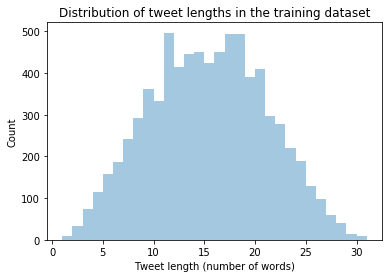

In [9]:
plt.figure()
sns.distplot(train_tweets['text_length'], kde=False, bins=30)
plt.title('Distribution of tweet lengths in the training dataset')
plt.xlabel('Tweet length (number of words)')
plt.ylabel('Count');

In [10]:
train_tweets['text_length'].mode()

0    11
dtype: int64

For the training set, the average `text_length` is about 15 words, the max is 31 words, and the mode is 11 words. The distributions of tweet lengths for the training set will be compared later with that of the test set, to check that they are similar and ensure that the model that is developed will generalize well to the test set.

Next, duplicate tweets are checked for and removed if found. A duplicate tweet has the same `text` and `target` values.

In [11]:
train_tweets_dup = train_tweets[train_tweets.duplicated(['text','target'], keep=False)]
train_tweets_dup

,keyword,location,text,target,text_length
id,,,,,
59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0,8
68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0,8
156,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz,0,16
165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz,0,16
171,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/THyzOMVWU0 | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/83jOO0xk29,0,16
...,...,...,...,...,...
10855,NaN,NaN,Evacuation order lifted for town of Roosevelt: http://t.co/EDyfo6E2PU http://t.co/M5KxLPKFA1,1,9
10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Reno Oklahoma Tornado Nearly Runs Over ... - http://t.co/3SICroAaNz http://t.co/I27Oa0HISp,1,16
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,20


In [12]:
train_tweets.drop_duplicates(['text','target'], inplace=True)

It may be possible that two tweets have the same `text` value, but differing `target` labels, since the labels were likely hand assigned. Contradictory class labelling could make a machine learning model harder to train, so these instances are found and then removed. As shown below, there are a small enough number of contradictory class labels that it is possible to manually inspect each pair to determine which one to keep.

In [13]:
train_tweets_diff = train_tweets[train_tweets.duplicated(['text'], keep=False)]
train_tweets_diff[['text','target']]

,text,target
id,,
881,To fight bioterrorism sir.,1
898,To fight bioterrorism sir.,0
1723,Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...,1
1752,I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????,0
1760,like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,1
1922,Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...,0
1950,like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,0
1968,I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????,1
4068,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1


In [14]:
train_drop_id = [881, 1723, 1760, 1968, 4068, 
                 4659, 5662, 5996, 6012, 6097, 
                 6112, 6113, 6123, 6134, 6223, 
                 6537, 8644, 8698, 9472]

train_tweets.drop(train_drop_id, axis=0, inplace=True)

Finally, special characters and URL's are removed from the tweets, to leave only words separated by spaces.

In [15]:
import re

# function to remove special characters from a string
def remove_special_chars(text):
    return re.sub(r'[^A-Za-z0-9 ]+', '', text)

# function to remove url from a string
def remove_url(text):
    return re.sub(r'http\S+', '', text)

In [16]:
train_tweets['text'] = train_tweets['text'].apply(lambda text: remove_special_chars(text))
train_tweets['text'] = train_tweets['text'].apply(lambda text: remove_url(text))
train_tweets

,keyword,location,text,target,text_length
id,,,,,
1,NaN,NaN,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,1,13
4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,7
5,NaN,NaN,All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected,1,22
6,NaN,NaN,13000 people receive wildfires evacuation orders in California,1,8
7,NaN,NaN,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,1,16
...,...,...,...,...,...
10863,NaN,NaN,WorldNews Fallen powerlines on Glink tram UPDATE FIRE crews have evacuated up to 30 passengers who were tr,1,19
10864,NaN,NaN,on the flip side Im at Walmart and there is a bomb and everyone had to evacuate so stay tuned if I blow up or not,1,26
10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site mosque Reuters via World Google News Wall,1,20


### 4.2 Test Data Analysis and Cleaning

The same analysis and cleaning procedure is applied to the test data set, with a couple exceptions. Duplicate tweets are not dropped from the test set, as the Kaggle evaluation system expects predictions for a complete test set. It is also not possible to assess if there are contradictory class labels for pairs of tweets, since there are no class labels in the test set.

In [17]:
test_tweets = pd.read_csv('test.csv', index_col='id')

In [18]:
test_tweets

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...
10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn
10865,NaN,NaN,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power
10868,NaN,NaN,Green Line derailment in Chicago http://t.co/UtbXLcBIuY


In [19]:
test_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3263 entries, 0 to 10875
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   3237 non-null   object
 1   location  2158 non-null   object
 2   text      3263 non-null   object
dtypes: object(3)
memory usage: 102.0+ KB


In [20]:
test_tweets['text_length'] = test_tweets['text'].str.split().str.len()
test_tweets.head()

,keyword,location,text,text_length
id,,,,
0,NaN,NaN,Just happened a terrible car crash,6
2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.",9
3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",19
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,4
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,8


In [21]:
test_tweets['text_length'].describe()

count    3263.000000
mean       14.965369
std         5.783576
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: text_length, dtype: float64

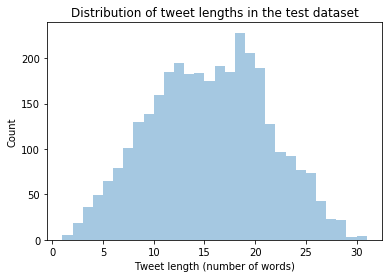

In [22]:
plt.figure()
sns.distplot(test_tweets['text_length'], kde=False, bins=30)
plt.title('Distribution of tweet lengths in the test dataset')
plt.xlabel('Tweet length (number of words)')
plt.ylabel('Count');

In [23]:
test_tweets['text_length'].mode()

0    18
dtype: int64

The distribution of tweet lengths in the test dataset appears very similar to the training set. For the test set, the average is 15, the max is 31, and the mode is 18.

Similar training and test set distributions allow for a validation set to be created from the training data that will have the same distribution as the test set. A validation set that has the same distribution as the test set is important because models that are developed will be evaluated on the validation set, and so will be evaluated against similar data as in the test set, which is ultimately what the final model will be scored on for the competition.

In [24]:
test_tweets_dup = test_tweets[test_tweets.duplicated(['text'], keep=False)]
test_tweets_dup

,keyword,location,text,text_length
id,,,,
152,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/THyzOMVWU0 | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/83jOO0xk29,16
177,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/THyzOMVWU0 | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/83jOO0xk29,16
408,apocalypse,NaN,#AskConnor there's a zombie apocalypse. the item to your right is your weapon. you're either screwed or you're gonna live.,20
922,bioterrorism,NaN,To fight bioterrorism sir.,4
924,bioterrorism,NaN,To fight bioterrorism sir.,4
1668,bombing,Somewhere on the Earth,70 yrs since the atomic bombing of Hiroshima... Terrible mass murder...,11
1765,buildings%20burning,US of Eh,.@denisleary Not sure how these folks rush into burning buildings but I'm grateful they do. #TrueHeroes,16
1947,burning%20buildings,US of Eh,.@denisleary Not sure how these folks rush into burning buildings but I'm grateful they do. #TrueHeroes,16
1982,bush%20fires,NaN,Bushfire causes first victim in Albania :: The multiple fires in Albania have caused the first vict http://t.co/yuba6XmBlq #Bush,19


In [25]:
# No duplicate tweets are dropped from the test set, 
# as the Kaggle evaluation system expects predictions for a complete test set
#test_tweets.drop_duplicates(['text'], inplace=True)

In [26]:
test_tweets['text'] = test_tweets['text'].apply(lambda text: remove_special_chars(text))
test_tweets['text'] = test_tweets['text'].apply(lambda text: remove_url(text))
test_tweets

,keyword,location,text,text_length
id,,,,
0,NaN,NaN,Just happened a terrible car crash,6
2,NaN,NaN,Heard about earthquake is different cities stay safe everyone,9
3,NaN,NaN,there is a forest fire at spot pond geese are fleeing across the street I cannot save them all,19
9,NaN,NaN,Apocalypse lighting Spokane wildfires,4
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,8
...,...,...,...,...
10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES SAFETY FASTENERS XrWn,8
10865,NaN,NaN,Storm in RI worse than last hurricane My cityamp3others hardest hit My yard looks like it was bombed Around 20000K still without power,23
10868,NaN,NaN,Green Line derailment in Chicago,6


### 4.3 Vectorization

In this section, the text of each tweet will be vectorized, or turned into a form that can be fed into a neural network.


#### 4.3.1 Step 1: Obtaining values from DataFrames

The training and test data values from the pandas DataFrames are copied into `train_text`, `train_labels` and `test_text` numpy arrays. Only the `text` and `target` values are used.

In [27]:
train_text = train_tweets['text'].values
train_labels = train_tweets['target'].values

test_text = test_tweets['text'].values

In [28]:
print('Train text shape: ', train_text.shape)
print('Train labels shape: ', train_labels.shape)

print('Test text shape: ', test_text.shape)

Train text shape:  (7502,)
Train labels shape:  (7502,)
Test text shape:  (3263,)


#### 4.3.2 Step 2: Tokenizing the tweets

A Tokenizer object `tokenizer` is created that looks through all of the tweets in `train_text`, and only takes into account the 10000 most common words (the value of `max_words`). The Tokenizer turns the text of each tweet into a sequence of numbers, where each number corresponds to a word. The sequences are then either padded with zeros, or truncated to a maximum length of 30 words (`maxlen`). A maximum length of 30 words is chosen since 31 words is the maximum present in the training and test sets, so selecting 30 words captures the omst words in the most tweets, resulting in minimal data loss.



In [29]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# maximum text length to consider
maxlen = 30
# maximum number of words in training set to consider, or the vocabulary size for this problem
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_text)
sequences = tokenizer.texts_to_sequences(train_text)

word_index = tokenizer.word_index
print('Number of unique tokens: ', len(word_index))

padded_sequences = pad_sequences(sequences, maxlen=maxlen)
print('Shape of padded sequences: ', padded_sequences.shape)
print('Shape of labels: ', train_labels.shape)

Number of unique tokens:  17965
Shape of padded sequences:  (7502, 30)
Shape of labels:  (7502,)


The variable `word_index` is a dictionary containing the mapping between words in the text and their tokens (numbers).

In [30]:
list(word_index.items())[:5]

[('the', 1), ('a', 2), ('in', 3), ('to', 4), ('of', 5)]

Below is an example of a tokenized tweet padded to a maximum length of 30 words, and its corresponding label:

In [31]:
padded_sequences[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,  105, 4369,   21,    1,  846,
          5,   18,  244,  123, 2030, 4370,   68,   37])

In [32]:
train_labels[0]

1

#### 4.3.3 Step 3: Creating training, validation and test sets

The number of validation samples `validation_samples` is set to 1000. The padded sequences from Step 2 are randomly shuffled and then split into training and validation sets `x_train`/`y_train` and `x_val`/`y_val`. Finally, the test data is tokenized in a similar manner as the training data, creating `x_test`.

In [33]:
# number of validation samples
validation_samples = 1000
# number of training samples (recall total_train_tweet_count variable from above)
training_samples = len(train_tweets) - validation_samples

np.random.seed(103)
indices = np.arange(padded_sequences.shape[0])
np.random.shuffle(indices)
padded_sequences = padded_sequences[indices]
train_labels = train_labels[indices]

x_train = padded_sequences[:training_samples]
y_train = train_labels[:training_samples]

x_val = padded_sequences[training_samples : training_samples + validation_samples]
y_val = train_labels[training_samples : training_samples + validation_samples]

In [34]:
print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)

print('x_val shape: ', x_val.shape)
print('y_val shape: ', y_val.shape)

x_train shape:  (6502, 30)
y_train shape:  (6502,)
x_val shape:  (1000, 30)
y_val shape:  (1000,)


In [35]:
# Process test data
# Note that tokenizer remains fitted to training data, a new tokenizer object is not created for the test data
# Note that there is no y_test, as there are no test labels provided in the dataset for this problem

test_sequences = tokenizer.texts_to_sequences(test_text)
x_test = pad_sequences(test_sequences, maxlen=maxlen)

In [36]:
print('x_test shape: ', x_test.shape)

x_test shape:  (3263, 30)


## 5. Develop a baseline model

To begin experimenting with different models, a simple baseline model is developed. In this case there are actually two baseline models developed, one that learns word embeddings from the training data, and one that uses pretrained word embeddings. Word embeddings are learned representations of words, where words with similar meanings are given similar numerical encodings. Word embeddings are stored in an embedding matrix, and so two words that are encoded with vectors that are close to each other will have similar meanings.

Since the training set only contains 6502 samples of 30 words it may not be large enough to learn effective representations of the words, so to compare a second baseline model will be developed using pretrained embeddings, and will be explained below.

### 5.1 Baseline model using learned word embeddings

The baseline model using learned word embeddings utilizes the Keras Embedding layer, followed by a hidden Dense layer and finally a Dense output layer with sigmoid activation, since this problem is a binary classification. 

The Embedding layer parameters are set to expect 10000 maximum word tokens (`max_words`), an embedding dimension of 100 (to match the baseline model using pretrained word embeddings, described in the next section) and an input length of 30 words (`maxlen`). The Embedding layer takes in data of shape (number of samples, sequence length) and outputs data with a shape of (number of samples, sequence length, embedding dimension). The embedding dimension is the length of the vectors used to represent words.

As an initial guess, the model is trained for a small number of epochs, in this case 10.

In [37]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, 100, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1000000   
_________________________________________________________________
flatten (Flatten)            (None, 3000)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                96032     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,096,065
Trainable params: 1,096,065
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [39]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val,y_val))

Epoch 1/10
51/51 [==============================] - 1s 25ms/step - loss: 0.6584 - acc: 0.5820 - val_loss: 0.6049 - val_acc: 0.6400
Epoch 2/10
51/51 [==============================] - 1s 17ms/step - loss: 0.4865 - acc: 0.7936 - val_loss: 0.4796 - val_acc: 0.7820
Epoch 3/10
51/51 [==============================] - 1s 20ms/step - loss: 0.2194 - acc: 0.9269 - val_loss: 0.5031 - val_acc: 0.7720
Epoch 4/10
51/51 [==============================] - 1s 19ms/step - loss: 0.1044 - acc: 0.9695 - val_loss: 0.5638 - val_acc: 0.7770
Epoch 5/10
51/51 [==============================] - 1s 22ms/step - loss: 0.0681 - acc: 0.9762 - val_loss: 0.6190 - val_acc: 0.7820
Epoch 6/10
51/51 [==============================] - 1s 20ms/step - loss: 0.0592 - acc: 0.9803 - val_loss: 0.6463 - val_acc: 0.7760
Epoch 7/10
51/51 [==============================] - 1s 20ms/step - loss: 0.0545 - acc: 0.9809 - val_loss: 0.6691 - val_acc: 0.7730
Epoch 8/10
51/51 [==============================] - 1s 20ms/step - loss: 0.0517 - a

To evaluate the model performance after training, several functions are created to make it easier to evaluate subsequent models that are developed. The functions are:

1. `create_val_plot` - generates training and validation loss and accuracy plots
2. `convert_to_classes` - converts class probabilities generated from the sigmoid activated output layer into class labels (1 for real disaster, 0 for no disaster)
3. `print_metrics` - uses scikit-learn metric functions (see https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) to evaluate model performance on the validation set
4. `evaluate_model` - combines the previous 3 functions into one function call

In [40]:
def create_val_plot(model_history):
        
    model_history = model_history.history

    # Training and validation loss plot
    loss_values = model_history['loss']
    val_loss_values = model_history['val_loss']

    epochs = range(1, len(loss_values) + 1)
    
    plt.figure()
    plt.plot(epochs, loss_values, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
        
    # Training and validation accuracy plot
    acc = model_history['acc']
    val_acc = model_history['val_acc']

    epochs = range(1, len(acc) + 1)
    
    plt.figure()
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

In [41]:
def convert_to_classes(predictions):
    class_array = np.zeros(predictions.shape)
    threshold = 0.5
    
    for i in range(0, len(predictions)):
        if predictions[i] >= threshold:
            class_array[i] = 1
        else:
            class_array[i] = 0
            
    return class_array

In [42]:
def print_metrics(y_true, y_pred):

    from sklearn.metrics import f1_score, classification_report, confusion_matrix

    print('Classification Report:')
    print(classification_report(y_true, y_pred))

    print('Confusion Matrix:')
    print(confusion_matrix(y_true, y_pred))
    print('\n')

    print('F1 Score: ', round(f1_score(y_true, y_pred), 5))

In [43]:
def evaluate_model(model_history):
    
    # Plot model training plots
    create_val_plot(model_history)
    
    # Generate predictions, convert from probabilities to class labels
    val_predictions = model.predict(x_val)
    val_predictions = convert_to_classes(val_predictions)
    
    # Print model performance metrics
    print_metrics(y_true=y_val, y_pred=val_predictions)

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       590
           1       0.74      0.66      0.70       410

    accuracy                           0.77      1000
   macro avg       0.76      0.75      0.75      1000
weighted avg       0.77      0.77      0.76      1000

Confusion Matrix:
[[497  93]
 [140 270]]


F1 Score:  0.69858


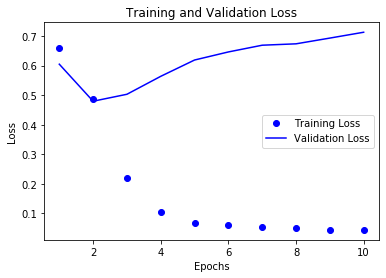

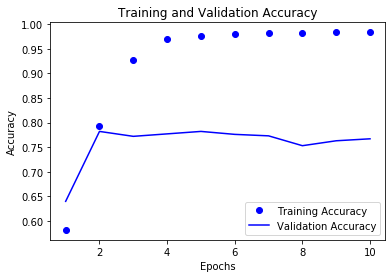

In [44]:
evaluate_model(model_history=history)

The model has an F1 score of 0.69858, and begins to overfit after 2 epochs, as evidenced by the validation accuracy not improving.

### 5.2 Baseline model using pretrained word embeddings

A second baseline model is developed using pretrained word embeddings from the Global Vectors for Word Representation database (GloVe, available at https://nlp.stanford.edu/projects/glove/). The GloVe embeddings are generated from a much larger dataset than what is used in this problem, and have the advantage of capturing word representations that are transferrable to this problem. The 100 dimensional embeddings file was downloaded (glove.6B.zip) and converted into an embeddings index using the code below:

In [45]:
embeddings_index = {}
glove_file = open('glove.6B.100d.txt', encoding='utf8')
for line in glove_file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
glove_file.close()

print('Found {} word vectors.'.format(len(embeddings_index)))

Found 400000 word vectors.


The `embeddings_index` dictionary shows how words are stored as embedding vector representations:

In [46]:
list(embeddings_index.items())[0]

('the',
 array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
        -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
         0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
        -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
         0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
        -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
         0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
         0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
        -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
        -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
        -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
        -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
        -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
        -1.2526  ,  0.071624, 

The following code creates an embedding matrix containing the pretrained weights that will be used in the Embedding layer of the neural network. For each word in the `word_index` generated by the Tokenizer in Section 4.3.2, its corresponding word embedding vector `embedding_vector` is created from its `embeddings_index` dictionary mapping. The `embedding_dimension` is set to 100, and as before only the 10000 top occuring words (`max_words`) are considered. As a result, a matrix of shape (10000, 100) is created that represents pretrained word embeddings.

In [47]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [48]:
embedding_matrix.shape

(10000, 100)

The neural network configuration is identical to the first baseline model:

In [49]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                96032     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,096,065
Trainable params: 1,096,065
Non-trainable params: 0
_________________________________________________________________


However, the pretrained GloVe embeddings in the first layer must be 'frozen', or set constant, otherwise they will be trained along with the rest of the network and their representations will be lost.

In [50]:
# freeze the GloVe embeddings
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [51]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [52]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val,y_val))

Epoch 1/10
51/51 [==============================] - 0s 6ms/step - loss: 0.5289 - acc: 0.7464 - val_loss: 0.4622 - val_acc: 0.7890
Epoch 2/10
51/51 [==============================] - 0s 4ms/step - loss: 0.4016 - acc: 0.8254 - val_loss: 0.4490 - val_acc: 0.8000
Epoch 3/10
51/51 [==============================] - 0s 4ms/step - loss: 0.3476 - acc: 0.8553 - val_loss: 0.4435 - val_acc: 0.8070
Epoch 4/10
51/51 [==============================] - 0s 3ms/step - loss: 0.3091 - acc: 0.8753 - val_loss: 0.4588 - val_acc: 0.7950
Epoch 5/10
51/51 [==============================] - 0s 4ms/step - loss: 0.2679 - acc: 0.8988 - val_loss: 0.4657 - val_acc: 0.8030
Epoch 6/10
51/51 [==============================] - 0s 3ms/step - loss: 0.2363 - acc: 0.9149 - val_loss: 0.5009 - val_acc: 0.7860
Epoch 7/10
51/51 [==============================] - 0s 3ms/step - loss: 0.2056 - acc: 0.9320 - val_loss: 0.5110 - val_acc: 0.8080
Epoch 8/10
51/51 [==============================] - 0s 3ms/step - loss: 0.1893 - acc: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       590
           1       0.78      0.71      0.75       410

    accuracy                           0.80      1000
   macro avg       0.80      0.79      0.79      1000
weighted avg       0.80      0.80      0.80      1000

Confusion Matrix:
[[509  81]
 [118 292]]


F1 Score:  0.74585


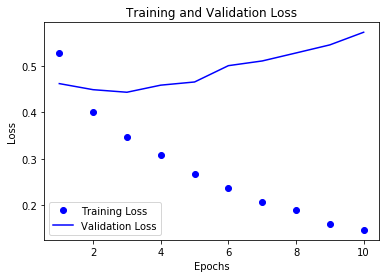

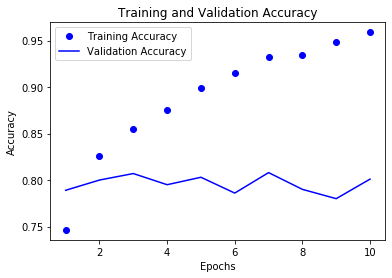

In [53]:
evaluate_model(model_history=history)

Using pretrained word embeddings results in a slight improvement in the F1 score, from 0.69858 to 0.74585. It still appears that the model is overfitting after 2 epochs, so the next sections will address how the F1 score is improved while reducing overfitting. Based on the results of the two baseline models it is still not clear if pretrained word embeddings are a benefit for this problem.

## 6. Scale up - developing a model that overfits

The baseline models began overfitting after only 2 epochs. To develop a model that has higher accuracy yet does not overfit to the training data, it is necessary to use a different type of model. In this section, a Long Short Term (LSTM) hidden layer will be used instead of a Dense hidden layer, resulting in a Recurrent Neural Network (RNN). The LSTM layer is more suitable for modelling text sequences because it saves information from earlier in the sequence for later, carrying information across each step in the text sequence.

Since it is still not clear whether pretrained word embeddings are a benefit for this problem, two identical model structures will be trained using 32 LSTM units, however the first will learn word embeddings and the second will use pretrained GloVe embeddings as before.

### 6.1 LSTM model using learned word embeddings

In [54]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 100)           1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [56]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val,y_val))

Epoch 1/10
51/51 [==============================] - 2s 31ms/step - loss: 0.6293 - acc: 0.6469 - val_loss: 0.5227 - val_acc: 0.7860
Epoch 2/10
51/51 [==============================] - 1s 25ms/step - loss: 0.4005 - acc: 0.8365 - val_loss: 0.4525 - val_acc: 0.7900
Epoch 3/10
51/51 [==============================] - 1s 28ms/step - loss: 0.2668 - acc: 0.8970 - val_loss: 0.4881 - val_acc: 0.7890
Epoch 4/10
51/51 [==============================] - 1s 27ms/step - loss: 0.1934 - acc: 0.9277 - val_loss: 0.5542 - val_acc: 0.7780
Epoch 5/10
51/51 [==============================] - 2s 30ms/step - loss: 0.1461 - acc: 0.9488 - val_loss: 0.6151 - val_acc: 0.7860
Epoch 6/10
51/51 [==============================] - 2s 40ms/step - loss: 0.1116 - acc: 0.9625 - val_loss: 0.6991 - val_acc: 0.7820
Epoch 7/10
51/51 [==============================] - 2s 32ms/step - loss: 0.0951 - acc: 0.9688 - val_loss: 0.7944 - val_acc: 0.7630
Epoch 8/10
51/51 [==============================] - 2s 33ms/step - loss: 0.0804 - a

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.82       590
           1       0.76      0.66      0.71       410

    accuracy                           0.78      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.77      0.78      0.77      1000

Confusion Matrix:
[[504  86]
 [139 271]]


F1 Score:  0.70665


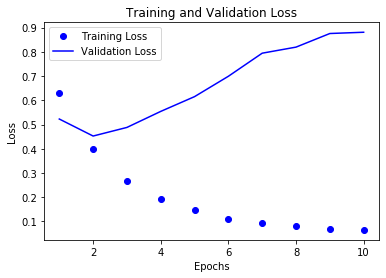

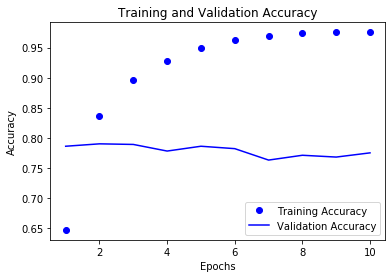

In [57]:
evaluate_model(model_history=history)

The LSTM model using learned word embeddings is not performing much better than baseline, with an F1 score of 0.70665, and is still overfitting.

### 6.2 LSTM mode using pretrained word embeddings

In [58]:

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________


In [59]:
# freeze the GloVe embeddings
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [60]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [61]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val,y_val))

Epoch 1/10
51/51 [==============================] - 1s 20ms/step - loss: 0.5644 - acc: 0.7267 - val_loss: 0.5189 - val_acc: 0.7490
Epoch 2/10
51/51 [==============================] - 1s 12ms/step - loss: 0.4521 - acc: 0.8011 - val_loss: 0.4615 - val_acc: 0.7970
Epoch 3/10
51/51 [==============================] - 1s 13ms/step - loss: 0.4301 - acc: 0.8144 - val_loss: 0.4590 - val_acc: 0.7900
Epoch 4/10
51/51 [==============================] - 1s 14ms/step - loss: 0.4130 - acc: 0.8194 - val_loss: 0.4542 - val_acc: 0.8000
Epoch 5/10
51/51 [==============================] - 1s 15ms/step - loss: 0.4040 - acc: 0.8248 - val_loss: 0.4493 - val_acc: 0.8050
Epoch 6/10
51/51 [==============================] - 1s 14ms/step - loss: 0.3947 - acc: 0.8285 - val_loss: 0.4469 - val_acc: 0.8040
Epoch 7/10
51/51 [==============================] - 1s 14ms/step - loss: 0.3893 - acc: 0.8308 - val_loss: 0.4554 - val_acc: 0.8000
Epoch 8/10
51/51 [==============================] - 1s 15ms/step - loss: 0.3831 - a

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       590
           1       0.78      0.70      0.74       410

    accuracy                           0.80      1000
   macro avg       0.79      0.78      0.79      1000
weighted avg       0.80      0.80      0.79      1000

Confusion Matrix:
[[510  80]
 [123 287]]


F1 Score:  0.73874


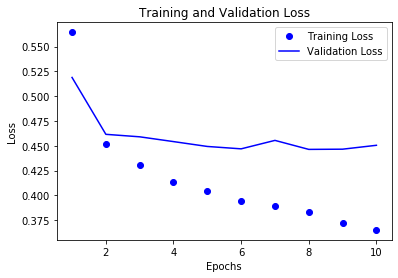

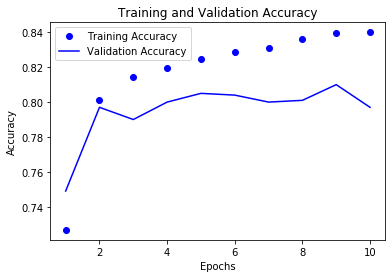

In [62]:
evaluate_model(model_history=history)

The LSTM model using pretrained word embeddings has improved over the baseline with an F1 score of 0.73874. In addition,  the model does not begin to overfit until 4 epochs, another improvement over baseline. Since an LSTM model using pretrained word embeddings appears to be more resistant to overfitting, it will be the basis for further development.

## 7. Adding regularization and tuning hyperparameters

To improve the F1 score of the LSTM model using pretrained word embeddings from Section 6.2, several experiments were conducted that varied the following parameters:

* Number of LSTM units (32 vs 64)
* Adding a second LSTM layer (with 32 or 64 layers)
* Adding recurrent dropout
* Adding L2 regularization
* Increasing the number of training epochs (20, 30 and 50)

After varying the parameters listed above, a final model configuration was reached.

### 7.1 Final model configuration

The code below illustrates the optimum model that has been found, with a goal of maximizing the F1 score while reducing overfitting.


In [63]:
from keras import regularizers

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 100)           1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 1,042,305
Trainable params: 1,042,305
Non-trainable params: 0
_________________________________________________________________


In [64]:
# freeze the GloVe embeddings
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [65]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [66]:
history = model.fit(x_train, y_train, epochs=30, batch_size=128, validation_data=(x_val,y_val))

Epoch 1/30
51/51 [==============================] - 3s 61ms/step - loss: 0.6941 - acc: 0.6984 - val_loss: 0.6031 - val_acc: 0.7640
Epoch 2/30
51/51 [==============================] - 3s 60ms/step - loss: 0.5578 - acc: 0.7801 - val_loss: 0.5387 - val_acc: 0.7930
Epoch 3/30
51/51 [==============================] - 3s 61ms/step - loss: 0.5317 - acc: 0.7887 - val_loss: 0.5106 - val_acc: 0.7930
Epoch 4/30
51/51 [==============================] - 3s 56ms/step - loss: 0.5133 - acc: 0.7870 - val_loss: 0.5082 - val_acc: 0.7970
Epoch 5/30
51/51 [==============================] - 3s 59ms/step - loss: 0.4981 - acc: 0.7971 - val_loss: 0.5110 - val_acc: 0.7990
Epoch 6/30
51/51 [==============================] - 3s 64ms/step - loss: 0.4998 - acc: 0.7868 - val_loss: 0.4965 - val_acc: 0.8010
Epoch 7/30
51/51 [==============================] - 3s 60ms/step - loss: 0.4911 - acc: 0.7979 - val_loss: 0.4907 - val_acc: 0.8020
Epoch 8/30
51/51 [==============================] - 3s 59ms/step - loss: 0.4788 - a

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       590
           1       0.82      0.67      0.74       410

    accuracy                           0.81      1000
   macro avg       0.81      0.78      0.79      1000
weighted avg       0.81      0.81      0.80      1000

Confusion Matrix:
[[532  58]
 [137 273]]


F1 Score:  0.73684


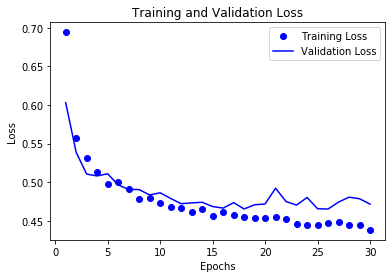

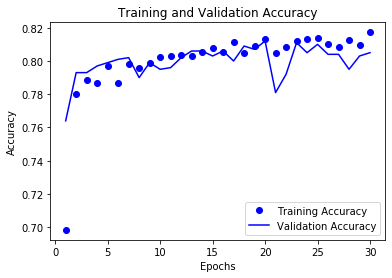

In [67]:
evaluate_model(model_history=history)

The performance of the final model configuration is similar to the baseline models, with an F1 score of 0.73684. The final model appears to resist overfitting for most of the training epochs; the validation loss and accuracy start to plateau after about 20 epochs. It is hoped that the final model, although not having improvements in F1 score over the baseline, will still generalize well to the test dataset.

If an LSTM layer is well suited to this problem, then perhaps the performance acheived here is approaching the maximum possible. Otherwise, other model structures should be investigated to see if further improvements to the F1 score can be made.

### 7.2 Training final model configuration on the complete training data set

The following code shows how the final model configuration is re-trained on the complete training data set.

In [68]:
x_train_full = padded_sequences
y_train_full = train_labels

print('Complete training sequences size: ', x_train_full.shape)
print('Complete training labels size: ', y_train_full.shape)

Complete training sequences size:  (7502, 30)
Complete training labels size:  (7502,)


In [69]:
history_full = model.fit(x_train_full, y_train_full, epochs=30, batch_size=128)

Epoch 1/30
59/59 [==============================] - 4s 69ms/step - loss: 0.4461 - acc: 0.8140
Epoch 2/30
59/59 [==============================] - 4s 73ms/step - loss: 0.4504 - acc: 0.8106
Epoch 3/30
59/59 [==============================] - 4s 66ms/step - loss: 0.4402 - acc: 0.8170
Epoch 4/30
59/59 [==============================] - 4s 65ms/step - loss: 0.4464 - acc: 0.8144
Epoch 5/30
59/59 [==============================] - 4s 66ms/step - loss: 0.4374 - acc: 0.8183
Epoch 6/30
59/59 [==============================] - 4s 72ms/step - loss: 0.4434 - acc: 0.8158
Epoch 7/30
59/59 [==============================] - 4s 67ms/step - loss: 0.4396 - acc: 0.8152
Epoch 8/30
59/59 [==============================] - 4s 67ms/step - loss: 0.4354 - acc: 0.8186
Epoch 9/30
59/59 [==============================] - 4s 70ms/step - loss: 0.4326 - acc: 0.8202
Epoch 10/30
59/59 [==============================] - 4s 71ms/step - loss: 0.4430 - acc: 0.8146
Epoch 11/30
59/59 [==============================] - 4s 67m

### 7.3 Generating predictions and a submission file

Once the final model is retrained on the complete training set, predictions are made on the test set. A submission file is generated that is sent to Kaggle for scoring.

In [70]:
predictions = model.predict(x_test)
predictions

array([[0.54284495],
       [0.818486  ],
       [0.7005893 ],
       ...,
       [0.6982952 ],
       [0.79482883],
       [0.50136065]], dtype=float32)

In [71]:
print('Shape of predictions array:' , predictions.shape)

Shape of predictions array: (3263, 1)


In [72]:
def predict_to_binary_class(predictions):
    
    threshold = 0.5
    predictions_classes = np.zeros((predictions.shape[0]))
    for i in range(0,len(predictions)):
        if predictions[i] >= 0.5:
            predictions_classes[i] = 1
        else:
            predictions_classes[i] = 0
    
    predictions_classes = predictions_classes.astype('int')
    return predictions_classes

predictions_classes = predict_to_binary_class(predictions)

In [73]:
predictions_id = test_tweets.index.values

In [74]:
predictions_df = pd.DataFrame({'id': predictions_id, 'target': predictions_classes})
predictions_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [75]:
predictions_df.to_csv('submission2.csv', index=False)

After submitting predictions on the test set to Kaggle for scoring, the F1 score of the final model configuration is 0.80937, which is a 16% improvement over the baseline model that used learned word embeddings. The extra effort to reduce overfitting in the final model resulted in a model that generalized well to the unseen data in the test set.

##  8. Conclusion

To classify whether tweets are about real natural disasters or not, a recurrent neural network has been developed using a LSTM hidden layer and pretrained GloVe embeddings and includes both dropout and L2 regularization. Predictions on the test dataset have been submitted to Kaggle and received an F1 score of 0.80937.

## 9. References

Portions of the code in Section 4.3 and Section 5 of this notebook have been adapted from the following source:

F. Chollet, "Working with text data" in Deep Learning with Python, 1st ed., Manning, 2018, pp. 180-195.